Importing Required Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
import shap

c:\Users\admin\OneDrive\Desktop\GuviCapstone\Microsoft capstone project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Importing Processed train data

In [2]:
#importing processed train data
traindata = pd.read_csv(r'C:\Users\admin\OneDrive\Desktop\GuviCapstone\Microsoft capstone project\traindata_processed.csv')
pd.set_option('display.max_columns', None)
traindata.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,IpAddress,Url,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueData,ApplicationName,OAuthApplicationId,FileName,ResourceIdName,OSVersion,City,Day,Year,Hour,Time
0,180388628218,0,612,123247,7,6,10,2,15,1,27,160396,453297,153085,529644,1631,860,3421,881,289573,3586,66,3,4,2024,6,21915
1,455266534868,88,326,210035,58,43,7,1,32,0,360606,160396,24887,153085,529644,1631,860,3421,881,289573,3586,66,10630,14,2024,3,10885
2,1056561957389,809,58352,712507,423,298,10,1,31,1,360606,68652,453297,153085,529644,1631,860,3421,881,289573,3586,66,10630,13,2024,4,17575
3,1279900258736,92,32992,774301,2,2,1,0,31,1,360606,13,453297,153085,529644,1631,860,3421,881,289573,3586,66,10630,10,2024,16,59976
4,214748368522,148,4359,188041,9,74,6,2,32,0,360606,160396,479,153085,529644,1631,860,3421,881,289573,3586,66,10630,15,2024,1,4087


In [3]:
traindata.shape

(8922805, 27)

Defining features (X) and target (y)

In [4]:
X = traindata.drop(columns=['IncidentGrade','Id'])  
y = traindata['IncidentGrade']                 # Target column

In [5]:
# Stratified train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [6]:
# Checking class distribution in training and validation sets
print("Training set class distribution:\n", y_train.value_counts(normalize=True))
print("Validation set class distribution:\n", y_val.value_counts(normalize=True))

Training set class distribution:
 IncidentGrade
0    0.428991
2    0.351921
1    0.219088
Name: proportion, dtype: float64
Validation set class distribution:
 IncidentGrade
0    0.428991
2    0.351921
1    0.219088
Name: proportion, dtype: float64


Model Selection and Training

Baseline Models

In [7]:
# Baseline Models
baseline_models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42)
}

# Training and evaluation on validation set
for name, model in baseline_models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f"{name} Classification Report:\n", classification_report(y_val, y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))


Training Logistic Regression...
Logistic Regression Classification Report:
               precision    recall  f1-score   support

     Class 0       0.53      0.51      0.52   1148340
     Class 1       0.28      0.30      0.29    586464
     Class 2       0.55      0.56      0.55    942038

    accuracy                           0.48   2676842
   macro avg       0.45      0.45      0.45   2676842
weighted avg       0.48      0.48      0.48   2676842


Training Decision Tree...
Decision Tree Classification Report:
               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00   1148340
     Class 1       0.99      0.99      0.99    586464
     Class 2       1.00      1.00      1.00    942038

    accuracy                           1.00   2676842
   macro avg       1.00      1.00      1.00   2676842
weighted avg       1.00      1.00      1.00   2676842



Advanced Models

In [8]:
# Advanced models
advanced_models = {
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)}

# Additional libraries for XGBoost and LightGBM
try:
    advanced_models['XGBoost'] = XGBClassifier(scale_pos_weight=1, random_state=42,
                                                   tree_method='gpu_hist',  # Enable GPU
                                                    predictor='gpu_predictor')  # Use GPU for predictions
except ImportError:
    print("XGBoost not installed.")
    
try:
    advanced_models['LightGBM'] = LGBMClassifier(class_weight='balanced', random_state=42,device='gpu')  # Use GPU
except ImportError:
    print("LightGBM not installed.")

# Training and evaluation for advanced models
for name, model in advanced_models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f"{name} Classification Report:\n", classification_report(y_val, y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))


Training Random Forest...
Random Forest Classification Report:
               precision    recall  f1-score   support

     Class 0       0.98      0.99      0.99   1148340
     Class 1       0.98      0.98      0.98    586464
     Class 2       0.99      0.98      0.99    942038

    accuracy                           0.99   2676842
   macro avg       0.99      0.98      0.98   2676842
weighted avg       0.99      0.99      0.99   2676842


Training Gradient Boosting...
Gradient Boosting Classification Report:
               precision    recall  f1-score   support

     Class 0       0.72      0.95      0.82   1148340
     Class 1       0.88      0.59      0.70    586464
     Class 2       0.92      0.76      0.83    942038

    accuracy                           0.80   2676842
   macro avg       0.84      0.77      0.79   2676842
weighted avg       0.83      0.80      0.80   2676842


Training XGBoost...


c:\Users\admin\OneDrive\Desktop\GuviCapstone\Microsoft capstone project\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:47:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\admin\OneDrive\Desktop\GuviCapstone\Microsoft capstone project\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:47:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\admin\OneDrive\Desktop\GuviCapstone\Microsoft capstone project\.venv\Lib\site-packages\xgboost\core.py:158: Use

XGBoost Classification Report:
               precision    recall  f1-score   support

     Class 0       0.90      0.96      0.93   1148340
     Class 1       0.93      0.86      0.90    586464
     Class 2       0.95      0.92      0.93    942038

    accuracy                           0.92   2676842
   macro avg       0.93      0.91      0.92   2676842
weighted avg       0.92      0.92      0.92   2676842


Training LightGBM...
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3644
[LightGBM] [Info] Number of data points in the train set: 6245963, number of used features: 25
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1650, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (71.48 MB) transferred to GPU in 0.186444 secs. 1 sparse feature groups
[LightGBM] [Info] Start training fr

Model Selection
Baseline Models:
Logistic Regression:
Struggles with class imbalance, leading to a low macro-F1 score (0.48). Precision and recall vary significantly across classes, indicating that it's not well-suited for this problem.

Decision Tree:
Perfect scores suggest overfitting, especially given the high accuracy (0.99) on the training set.

Advanced Models:
Random Forest:
Achieves excellent macro-F1 (0.98), precision, and recall, suggesting it generalizes well. Likely robust due to ensemble averaging.

Gradient Boosting:
Balanced performance (macro-F1: 0.78), but lower than Random Forest and XGBoost.

XGBoost:
Best macro-F1 score (0.91) among all models. Good balance across precision, recall, and F1 scores for all classes, indicating strong handling of class imbalance.

LightGBM:
Strong results (macro-F1: 0.89), slightly underperforming compared to XGBoost. More efficient training but lower precision and recall for Class 0 compared to XGBoost.

Based on these results, we proceed with XGBoost as the final model since it shows the best overall performance.
XGBoost has the best macro F1-score (0.91) with balanced performance. But we can see Class Imbalance so using SMOTE
Taking Only 20% of the training data for computational efficeincy

In [9]:
# Sample 20% of the training data
X_train_sample = X_train.sample(frac=0.2, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

In [10]:
# Check the sizes
print("Original Training Data Size:", X_train.shape)
print("Sampled Training Data Size:", X_train_sample.shape)

Original Training Data Size: (6245963, 25)
Sampled Training Data Size: (1249193, 25)


SMOTE

In [11]:
# Applying SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_sample, y_train_sample)

In [12]:
# Checking the new class distribution
print("Original class distribution:\n", y_train_sample.value_counts())
print("After SMOTE class distribution:\n", y_train_smote.value_counts())

Original class distribution:
 IncidentGrade
0    536131
2    439189
1    273873
Name: count, dtype: int64
After SMOTE class distribution:
 IncidentGrade
2    536131
0    536131
1    536131
Name: count, dtype: int64


Training XGB model on class balanced data

In [13]:
# Training the XGBoost model
xgb = XGBClassifier(random_state=42,tree_method='hist',device='cuda')      
xgb.fit(X_train_smote, y_train_smote)

# Prediction on the validation set
y_val_pred = xgb.predict(X_val)

# Evaluate performance
print("Validation Set Classification Report (After SMOTE):")
print(classification_report(y_val, y_val_pred, target_names=['Class 0', 'Class 1', 'Class 2']))

Validation Set Classification Report (After SMOTE):
              precision    recall  f1-score   support

     Class 0       0.92      0.92      0.92   1148340
     Class 1       0.84      0.91      0.87    586464
     Class 2       0.95      0.90      0.93    942038

    accuracy                           0.91   2676842
   macro avg       0.90      0.91      0.91   2676842
weighted avg       0.91      0.91      0.91   2676842



SHAP Analysis for Feature Importance

In [14]:
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_val)

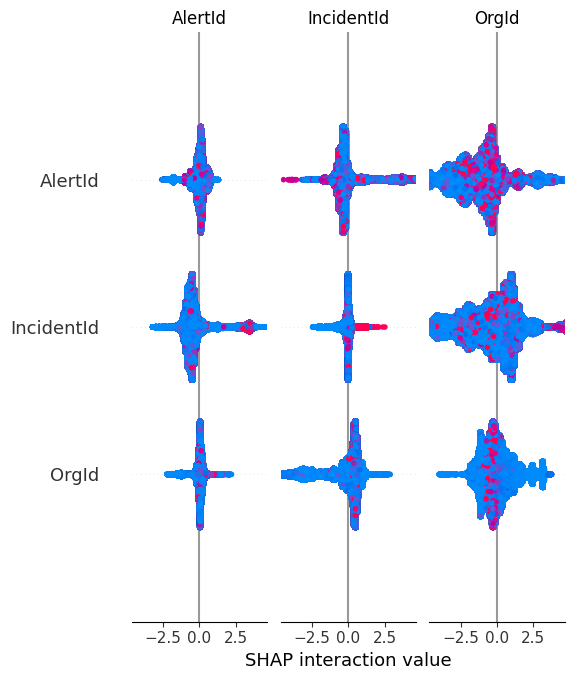

In [15]:
# Summary plot for feature importance
shap.summary_plot(shap_values, X_val, feature_names=X_val.columns)

In [16]:
# Defining top 11 features based on SHAP
top_11_features = ['OrgId', 'IncidentId', 'AlertTitle', 'DetectorId', 
                   'AlertId', 'Category', 'Hour', 'Time', 'Day', 'EntityType', 'City']

In [17]:
# Filter datasets for top 11 features
X_train_top11 = X_train_smote[top_11_features]
X_val_top11 = X_val[top_11_features]

In [18]:
# Verify shapes
print("Shape of training set with top features:", X_train_top11.shape)
print("Shape of validation set with top features:", X_val_top11.shape)

Shape of training set with top features: (1608393, 11)
Shape of validation set with top features: (2676842, 11)


Training XGB with only top 11 features

In [19]:
# Train the XGBoost model with top features
xgb_top11 = XGBClassifier(random_state=42,tree_method='hist',device='cuda')
xgb_top11.fit(X_train_top11, y_train_smote)

# Predict on the validation set
y_val_pred_top11 = xgb_top11.predict(X_val_top11)

# Evaluate performance

print("Validation Set Classification Report (Top 11 Features):")
print(classification_report(y_val, y_val_pred_top11, target_names=['Class 0', 'Class 1', 'Class 2']))

Validation Set Classification Report (Top 11 Features):
              precision    recall  f1-score   support

     Class 0       0.92      0.92      0.92   1148340
     Class 1       0.84      0.91      0.87    586464
     Class 2       0.95      0.91      0.93    942038

    accuracy                           0.91   2676842
   macro avg       0.91      0.91      0.91   2676842
weighted avg       0.92      0.91      0.92   2676842



In [22]:
# Loading test data
test_data = pd.read_csv(r'C:\Users\admin\OneDrive\Desktop\GuviCapstone\Microsoft capstone project\testdata_processed.csv')
test_data.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,IpAddress,Url,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueData,ApplicationName,OAuthApplicationId,FileName,ResourceIdName,OSVersion,City,Day,Year,Hour,Time
0,1245540519230,657,11767,87199,524,563,11,0,28,0,360606,160396,863,153085,529644,1631,860,3421,881,289573,3586,66,10630,4,2024,22,82520
1,1400159342154,3,91158,632273,2,2,1,0,15,0,360606,160396,453297,2833,529644,1631,860,3421,881,289573,3586,0,10630,3,2024,12,46649
2,1279900255923,145,32247,131719,2932,10807,11,0,23,1,360606,160396,453297,153085,529644,1631,860,3421,881,14,3586,66,10630,8,2024,3,12037
3,60129547292,222,15294,917686,0,0,10,1,7,1,360606,160396,453297,153085,529644,1631,860,3421,881,289573,3586,66,10630,12,2024,12,43594
4,515396080539,363,7615,5944,27,18,5,0,28,0,360606,160396,136104,153085,529644,1631,860,3421,881,289573,3586,66,10630,6,2024,17,63665


In [23]:
# Selecting only top 11 features and setting features and target
X_test_top11 = test_data[top_11_features] 
y_test = test_data['IncidentGrade']

In [24]:
# Predicting on the test set using the best model
y_test_pred_top11 = xgb_top11.predict(X_test_top11)

# Evaluate performance on test data
print("Test Set Classification Report (Top 11 Features):")
print(classification_report(y_test, y_test_pred_top11, target_names=['Class 0', 'Class 1', 'Class 2']))

Test Set Classification Report (Top 11 Features):
              precision    recall  f1-score   support

     Class 0       0.91      0.84      0.87   1752895
     Class 1       0.71      0.90      0.80    902664
     Class 2       0.93      0.87      0.90   1492329

    accuracy                           0.86   4147888
   macro avg       0.85      0.87      0.86   4147888
weighted avg       0.88      0.86      0.87   4147888



Without Using Smote

In [25]:
# Train the XGBoost model
xgb = XGBClassifier(random_state=42,tree_method='hist',device='cuda')
xgb.fit(X_train_sample, y_train_sample)

# Predict on the validation set
y_val_pred = xgb.predict(X_val)

# Evaluate performance
print("Validation Set Classification Report without smote:")
print(classification_report(y_val, y_val_pred, target_names=['Class 0', 'Class 1', 'Class 2']))

Validation Set Classification Report without smote:
              precision    recall  f1-score   support

     Class 0       0.90      0.96      0.93   1148340
     Class 1       0.94      0.86      0.89    586464
     Class 2       0.95      0.92      0.93    942038

    accuracy                           0.92   2676842
   macro avg       0.93      0.91      0.92   2676842
weighted avg       0.92      0.92      0.92   2676842



In [26]:
# Define top 11 features based on SHAP
top_11_features = ['OrgId', 'IncidentId', 'AlertTitle', 'DetectorId', 
                   'AlertId', 'Category', 'Hour', 'Time', 'Day', 'EntityType', 'City']

# Filter datasets for top 11 features
X_train_sample_top11 = X_train_sample[top_11_features]
X_val_top11 = X_val[top_11_features]

# Verify shapes
print("Shape of training set with top features:", X_train_sample_top11.shape)
print("Shape of validation set with top features:", X_val_top11.shape)

Shape of training set with top features: (1249193, 11)
Shape of validation set with top features: (2676842, 11)


Training XGB with only top 11 features on original dataset

In [27]:
# Train the XGBoost model with top features
xgb_top11 = XGBClassifier(random_state=42,tree_method='hist',device='cuda')
xgb_top11.fit(X_train_sample_top11, y_train_sample)

# Predict on the validation set
y_val_pred_top11 = xgb_top11.predict(X_val_top11)

# Evaluate performance

print("Validation Set Classification Report (Top 11 Features):")
print(classification_report(y_val, y_val_pred_top11, target_names=['Class 0', 'Class 1', 'Class 2']))

Validation Set Classification Report (Top 11 Features):
              precision    recall  f1-score   support

     Class 0       0.91      0.96      0.93   1148340
     Class 1       0.94      0.87      0.90    586464
     Class 2       0.95      0.92      0.94    942038

    accuracy                           0.93   2676842
   macro avg       0.93      0.92      0.92   2676842
weighted avg       0.93      0.93      0.93   2676842



In [29]:
# Predict on the test set
y_test_pred_top11 = xgb_top11.predict(X_test_top11)

# Evaluate performance on test data
print("Test Set Classification Report (Top 11 Features):")
print(classification_report(y_test, y_test_pred_top11, target_names=['Class 0', 'Class 1', 'Class 2']))

Test Set Classification Report (Top 11 Features):
              precision    recall  f1-score   support

     Class 0       0.87      0.92      0.90   1752895
     Class 1       0.89      0.82      0.86    902664
     Class 2       0.92      0.90      0.91   1492329

    accuracy                           0.89   4147888
   macro avg       0.90      0.88      0.89   4147888
weighted avg       0.89      0.89      0.89   4147888

